In [2]:
import os
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from itertools import combinations
import time

plt.style.use("ggplot")

In [3]:
class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None
    
    def start(self):
        self.end_time = None
        self.start_time = time.time()

    def end(self):
        self.end_time = time.time()

    def time(self):
        if self.start_time is None or self.end_time is None:
            raise ValueError()
        return self.end_time - self.start_time

# Config

In [4]:
class CFG:
    seed = 69
    is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
    
    if is_kaggle:
        data_wd = Path('/kaggle', 'input', 'optiver-trading-at-the-close')
    else:
        data_wd = Path.home() / '.data' / 'optiver-trading-at-the-close'

# Data

In [5]:
df = pd.read_csv(CFG.data_wd / 'train.csv')
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Stopping here since I'm spending way too much time on this. Will revisit this later.

# Feature Engineering

In [7]:
def add_features(input_df):
    df = input_df.copy()
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    # V1
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
    return df

df = df.pipe(add_features)

# Train / Test Split

In [9]:
count_date_ids = df.date_id.nunique()
test_size = 0.1
split_day = round((1 - test_size) * count_date_ids)
split_day

433

In [10]:
train_mask = df.date_id < split_day
train, valid = df[train_mask], df[~train_mask]

In [11]:
train.date_id.nunique(), valid.date_id.nunique()

(433, 48)

In [12]:
mask = ~df.target.isna()
X_train = train.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y_train = X_train.pop('target')

X_valid = valid.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y_valid = X_valid.pop('target')

# Modeling

In [13]:
mask = ~df.target.isna()
X = train.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y = X.pop('target')

## Grid Search

In [11]:
# model = lgb.LGBMRegressor(
#     random_state = CFG.seed, 
#     objective = 'mae', 
#     device_type = 'gpu',
#     verbosity=0
# )

In [14]:
# params_grid = dict(
#     learning_rate=[0.001, 0.01],
#     # n_estimators=[2**3, 2**4, 2**5],
#     num_leaves=[16, 32, 64], # large num_leaves helps improve accuracy but might lead to over-fitting
#     boosting_type= ['gbdt', 'dart'], # for better accuracy -> try dart
#     # max_bin=[256, 512], # large max_bin helps improve accuracy but might slow down training progress
#     # subsample= [0.7, 0.75],
#     reg_alpha= [1, 1.2],
#     reg_lambda= [1, 1.2, 1.4],
# )

In [15]:
# t = Timer()
# t.start()
# grid = GridSearchCV(model, params_grid, verbose=1, cv=4, n_jobs=3)
# grid.fit(X, y)
# t.end()

In [16]:
# print(grid.best_params_)

In [17]:
best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 64, 'reg_alpha': 1, 'reg_lambda': 1.4}

# Best Model

In [19]:
model = lgb.LGBMRegressor(
    random_state = CFG.seed, 
    objective = 'mae', 
    device_type = 'gpu',
    **best_params
)

if CFG.is_kaggle:
    model.fit(X_train, y_train)
else:
    model.fit(X, y)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8153
[LightGBM] [Info] Number of data points in the train set: 4709893, number of used features: 34
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (161.70 MB) transferred to GPU in 0.099356 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


LGBMRegressor(device_type='gpu', learning_rate=0.01, num_leaves=64,
              objective='mae', random_state=69, reg_alpha=1, reg_lambda=1.4)

In [20]:
if CFG.is_kaggle:
    train_mae = mean_absolute_error(model.predict(X_train), y_train)
    print(f'Train MAE: {train_mae:,.4f}')
    
    valid_mae = mean_absolute_error(model.predict(X_valid), y_valid)
    print(f'Validation MAE: {valid_mae:,.4f}')
else:
    mae = mean_absolute_error(model.predict(X), y)
    print(f'MAE: {mae:,.4f}')

Train MAE: 6.3606
Validation MAE: 5.8941


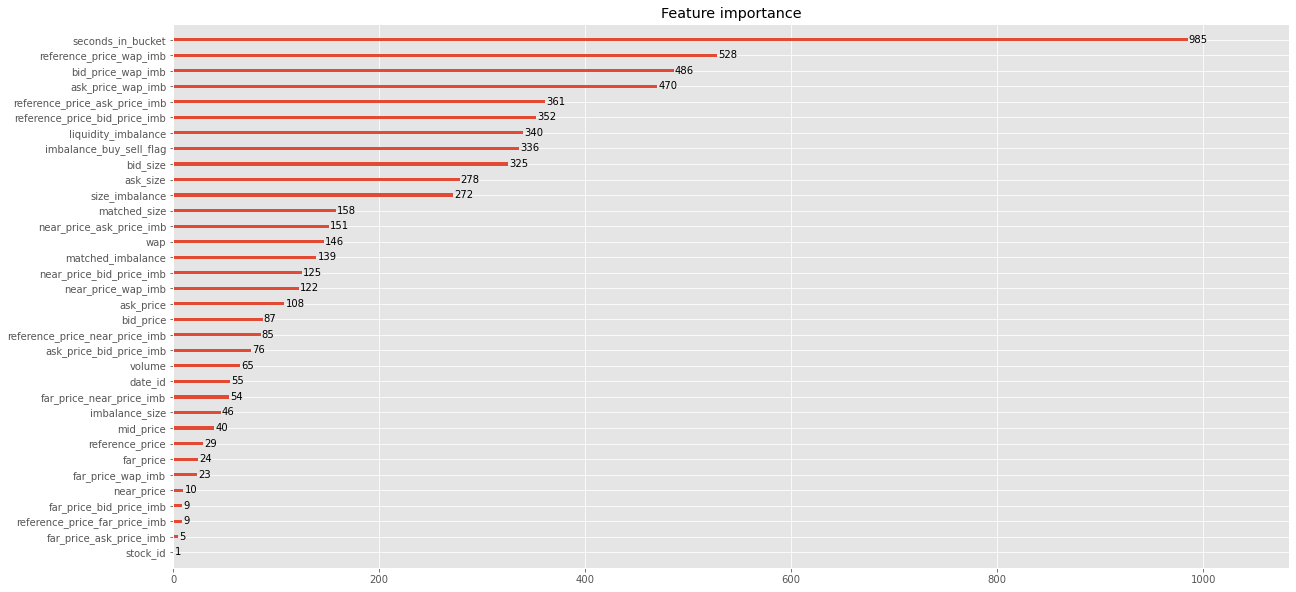

In [22]:
ax = lgb.plot_importance(
    model,
    figsize=(20, 10),
    xlabel='',
    ylabel='',
)
plt.show()

In [13]:
if CFG.is_kaggle:
    import optiver2023
    
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    
    counter = 0
    for (test, revealed_targets, sample_prediction) in iter_test:
        test = (test.drop(['row_id', 'currently_scored'], axis=1)
                .pipe(add_features))
        sample_prediction['target'] = model.predict(test)
        env.predict(sample_prediction)
        counter += 1